# Image Classification (Cats vs Dogs)
**Author:** *Mahdi Rafati (mehdirt)*

----

## Libraries

In [45]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from utils.train import train_model
from utils.data_utils import *
from utils.model_utils import *
from utils.predict_utils import *
from utils.vis_utils import *

# Some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [2]:
use_gpu

False

## Data

In [3]:
DATA_DIR = "data/"
os.listdir(DATA_DIR)

['test', 'train', 'val']

In [27]:
trn_dir = f"{DATA_DIR}train"
val_dir = f"{DATA_DIR}val"
test_dir = f"{DATA_DIR}test"

os.listdir(trn_dir)

['beige',
 'black',
 'blue',
 'brown',
 'gold',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'tan',
 'white',
 'yellow']

In [5]:
trn_fnames = glob.glob(f"{trn_dir}/*/*.jpg")
trn_fnames[:5]

['data/train\\beige\\00ecfeedea.jpg',
 'data/train\\beige\\012d5b3f87.jpg',
 'data/train\\beige\\02373872da.jpg',
 'data/train\\beige\\02c2e8bbc2.jpg',
 'data/train\\beige\\047c3235ad.jpg']

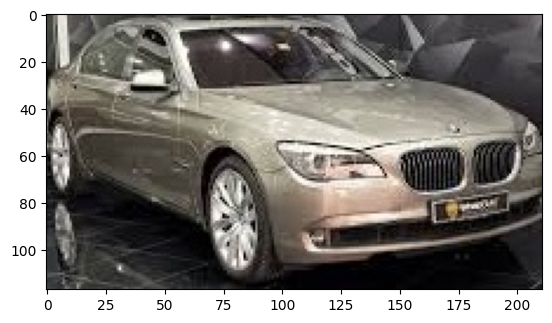

In [6]:
img = plt.imread(trn_fnames[15])
plt.imshow(img)

## Datasets and DataLoaders in Pytorch

In [7]:
train_ds = datasets.ImageFolder(trn_dir)
train_ds.classes

['beige',
 'black',
 'blue',
 'brown',
 'gold',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'tan',
 'white',
 'yellow']

In [8]:
print(train_ds.class_to_idx, train_ds.root, sep='\n')

{'beige': 0, 'black': 1, 'blue': 2, 'brown': 3, 'gold': 4, 'green': 5, 'grey': 6, 'orange': 7, 'pink': 8, 'purple': 9, 'red': 10, 'silver': 11, 'tan': 12, 'white': 13, 'yellow': 14}
data/train


In [9]:
train_ds.imgs[:10]

[('data/train\\beige\\00ecfeedea.jpg', 0),
 ('data/train\\beige\\012d5b3f87.jpg', 0),
 ('data/train\\beige\\02373872da.jpg', 0),
 ('data/train\\beige\\02c2e8bbc2.jpg', 0),
 ('data/train\\beige\\047c3235ad.jpg', 0),
 ('data/train\\beige\\04ee8952e9.jpg', 0),
 ('data/train\\beige\\05c8a236ac.jpg', 0),
 ('data/train\\beige\\0657543685.jpg', 0),
 ('data/train\\beige\\067ead93fc.jpg', 0),
 ('data/train\\beige\\06b9d192ff.jpg', 0)]

In [10]:
type(train_ds.transform)

NoneType

### Transformations

DataLoader object uses these transformations when loading data:

In [11]:
size = 224
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
tfms = transforms.Compose([
    transforms.Resize((size, size)), # PIL Image
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)
test_ds = datasets.ImageFolder(test_dir, transform=tfms)

In [29]:
len(train_ds), len(valid_ds), len(test_ds)

(7267, 1550, 1556)

### DataLoaders

In [30]:
train_dl = DataLoader(train_ds,
                     batch_size=batch_size,
                     shuffle=True,
                     num_workers=4)

valid_dl = DataLoader(valid_ds,
                     batch_size=batch_size,
                     shuffle=False,
                     num_workers=4)

test_dl = DataLoader(test_ds,
                     batch_size=batch_size,
                     shuffle=False,
                     num_workers=4)

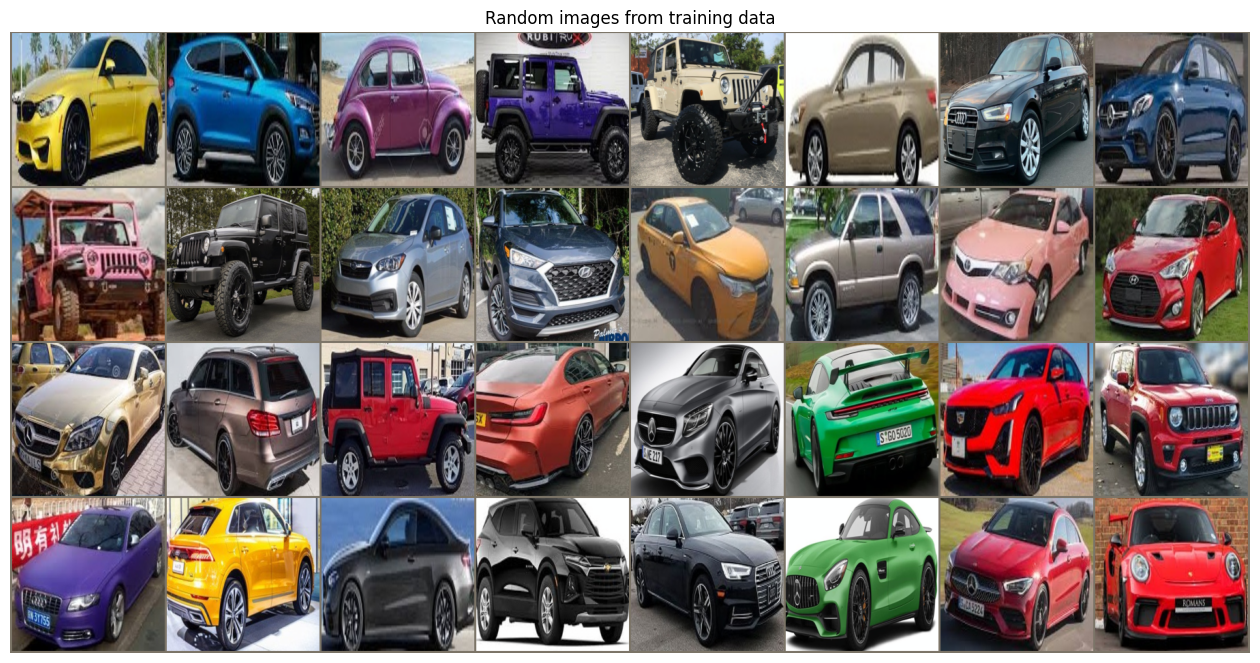

In [15]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title="Random images from training data")

## Transfer Learning

- Use a CNN already trained on different data (e.g. ImageNet)

- Just train the classifier weights (Last layer)

In [36]:
# Load pre-trained ResNet34
model = load_pretrained_resnet18(model_path=None, num_classes=15)
model = model.to(device)

c:\Users\A L F A\anaconda3\envs\cvision\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\A L F A\anaconda3\envs\cvision\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Loss Function and Optimizer

In [17]:
# loss and optmizer
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [18]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=num_epochs)

Epoch 1/10
----------
  train Loss: 0.92901 Acc: 0.69974
  valid Loss: 0.47519 Acc: 0.81871

Epoch 2/10
----------
  train Loss: 0.44681 Acc: 0.84547
  valid Loss: 0.41514 Acc: 0.85742

Epoch 3/10
----------
  train Loss: 0.25818 Acc: 0.91248
  valid Loss: 0.38073 Acc: 0.86903

Epoch 4/10
----------
  train Loss: 0.17429 Acc: 0.95060
  valid Loss: 0.44276 Acc: 0.85548

Epoch 5/10
----------
  train Loss: 0.09496 Acc: 0.97785
  valid Loss: 0.40674 Acc: 0.86774

Epoch 6/10
----------
  train Loss: 0.05440 Acc: 0.99174
  valid Loss: 0.43238 Acc: 0.86645

Epoch 7/10
----------
  train Loss: 0.04404 Acc: 0.99243
  valid Loss: 0.40967 Acc: 0.88194

Epoch 8/10
----------
  train Loss: 0.02950 Acc: 0.99628
  valid Loss: 0.44685 Acc: 0.86774

Epoch 9/10
----------
  train Loss: 0.02407 Acc: 0.99670
  valid Loss: 0.43341 Acc: 0.86710

Epoch 10/10
----------
  train Loss: 0.01802 Acc: 0.99697
  valid Loss: 0.43224 Acc: 0.87419

Training complete in 204m 44s
Best val Acc: 0.8819


## Load the Best trained model

In [46]:
model_path = "models/epoch-6-acc-0.88194.pth"
# Load the model with trained weights
model = load_finetuned_resnet18(model_path=model_path, num_classes=15, use_gpu=(device == "cuda"))
model = model.to(device)

c:\Users\A L F A\anaconda3\envs\cvision\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\A L F A\anaconda3\envs\cvision\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model weights loaded successfully!


## Analyze Results

In [47]:
def evaluate_model(model, dataloader, device):
    model.eval() 
    corrects = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()

    print(f"Accuracy: {100 * corrects / len(dataloader.dataset):.2f}")

### Accuracy on Validation Data

In [48]:
evaluate_model(model, valid_dl, device)

Accuracy: 88.19


### Accuracy on Test Data

In [49]:
evaluate_model(model, test_dl, device)

Accuracy: 87.21


### Accuracy on Training Data

In [50]:
evaluate_model(model, train_dl, device)

Accuracy: 99.92


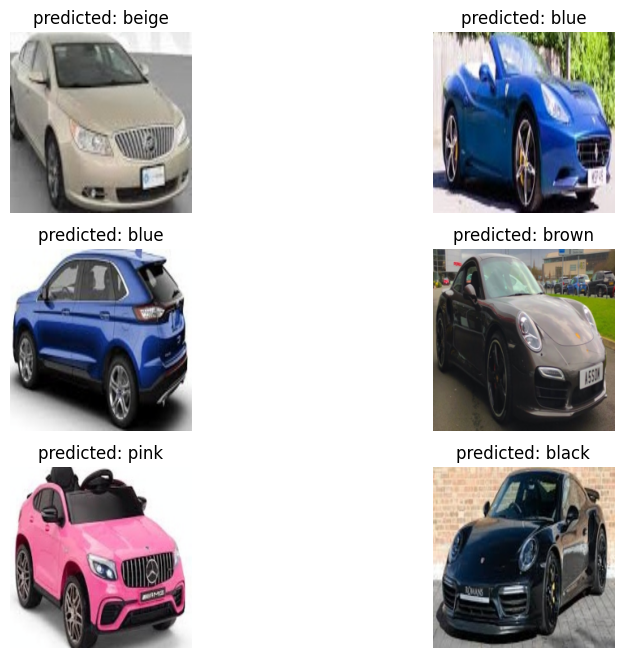

In [51]:
visualize_model(model, train_dl, device)

100%|██████████| 49/49 [02:05<00:00,  2.57s/it]


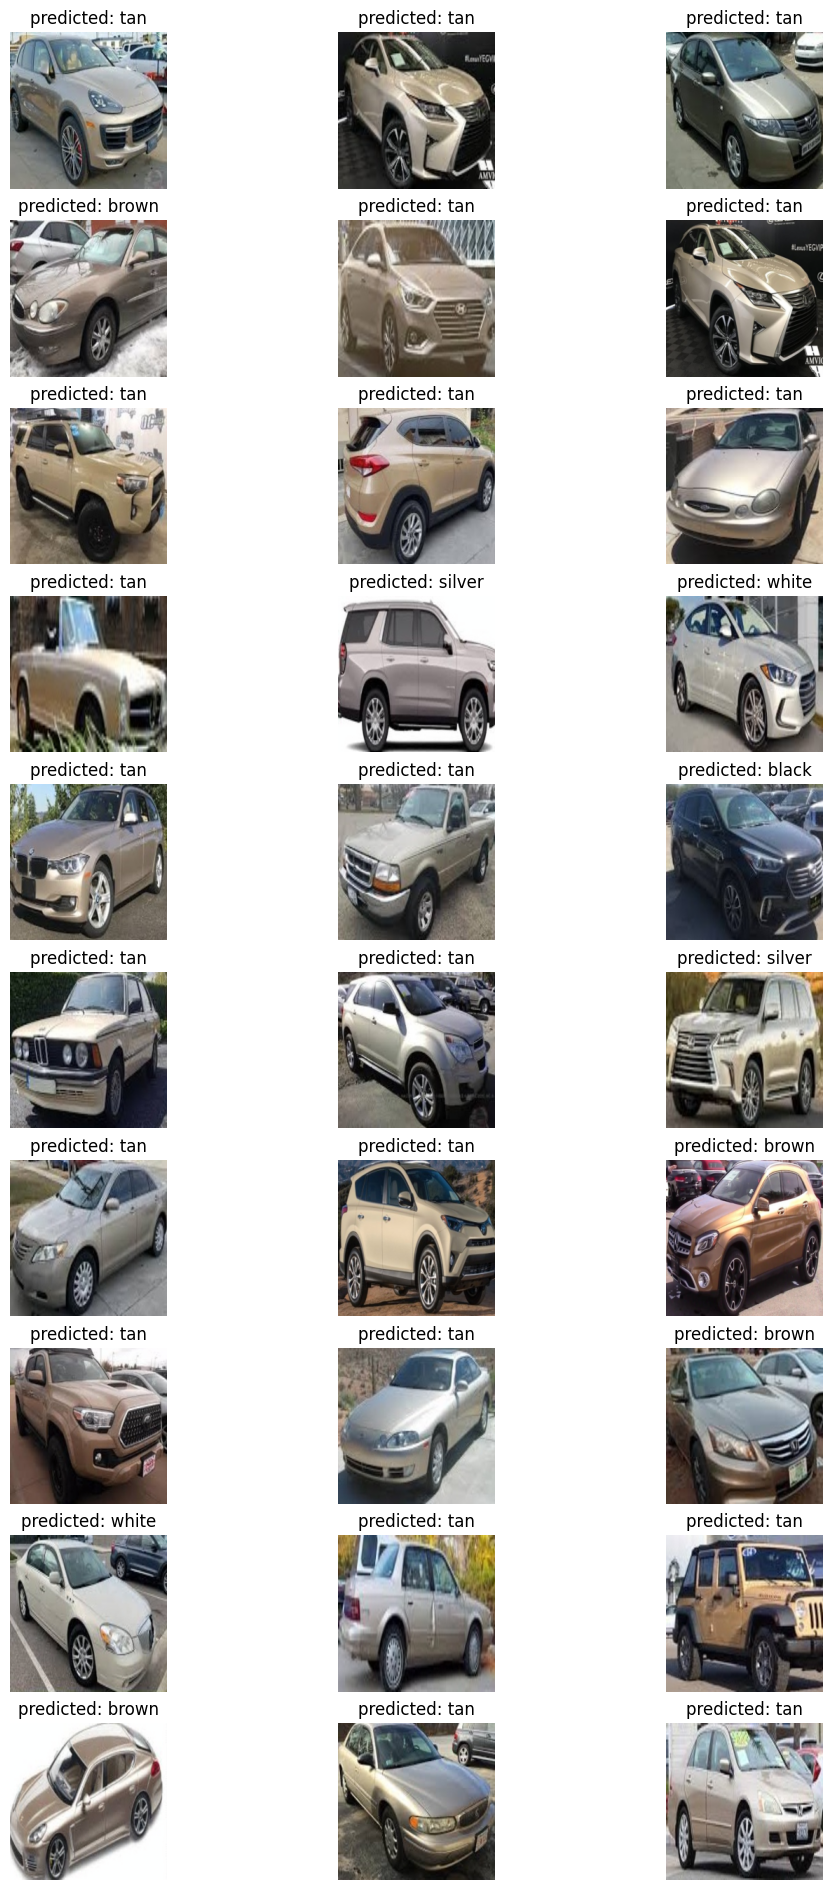

71 images out of 1550 were misclassified.


In [52]:
plot_errors(model, valid_dl, device)

### Confusion Matrix

100%|██████████| 49/49 [01:34<00:00,  1.93s/it]


[[0.64 0.01 0.   0.06 0.02 0.   0.   0.   0.   0.   0.   0.01 0.24 0.01
  0.  ]
 [0.   0.92 0.   0.01 0.   0.   0.07 0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.01 0.96 0.   0.   0.   0.02 0.   0.   0.   0.   0.01 0.   0.
  0.  ]
 [0.01 0.02 0.   0.88 0.   0.   0.02 0.01 0.   0.01 0.   0.   0.05 0.
  0.  ]
 [0.04 0.   0.   0.04 0.62 0.   0.   0.02 0.02 0.   0.   0.   0.09 0.
  0.16]
 [0.   0.01 0.01 0.   0.01 0.93 0.01 0.   0.   0.   0.   0.01 0.01 0.
  0.03]
 [0.   0.03 0.01 0.01 0.   0.   0.82 0.   0.   0.   0.   0.1  0.02 0.
  0.  ]
 [0.   0.   0.   0.02 0.01 0.   0.   0.93 0.01 0.   0.04 0.   0.   0.
  0.  ]
 [0.01 0.   0.   0.   0.   0.   0.   0.02 0.91 0.01 0.05 0.   0.   0.
  0.  ]
 [0.   0.01 0.03 0.   0.01 0.   0.   0.   0.   0.96 0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.02 0.01 0.   0.97 0.   0.   0.
  0.  ]
 [0.03 0.   0.   0.   0.   0.   0.13 0.01 0.   0.   0.   0.71 0.   0.12
  0.  ]
 [0.26 0.01 0.   0.09 0.01 0.   0.01 0.01 0.   0.   0.01 0.0

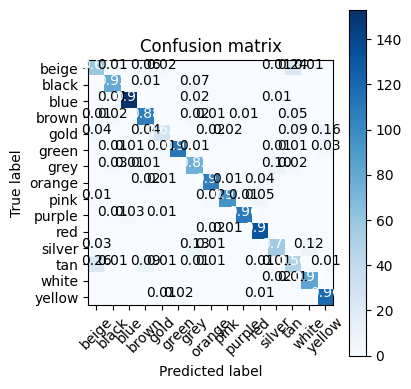

In [24]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

## Export the model to ONXX format

In [54]:
# Create a random input (adjust shape to your model's input size)
random_input = torch.randn(1, 3, 224, 224)  # (batch_size, channels, height, width)

# Export to ONNX
torch.onnx.export(
    model,                              # PyTorch model
    random_input,                       # Input tensor
    "models/color_classifier.onnx",     # Output file path (directly save here)
    input_names=["input"],              # Input tensor name
    output_names=["output"],            # Output tensor name
    opset_version=12                    # ONNX operator set version
)

print("Model successfully exported to models/color_classifier.onnx")

Model successfully exported to models/color_classifier.onnx


### Check ONNX model 

In [56]:
import onnx

onnx_model = onnx.load("models/color_classifier.onnx")
onnx.checker.check_model(onnx_model)

## Overfit

In case that the model is still overfitting, we turn to data augmentation.

### Data Augmentation

In [5]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{DATA_DIR}train", train_transforms)
valid_ds = datasets.ImageFolder(f"{DATA_DIR}valid", valid_transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=4)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print(f"Train size: {train_ds_sz}\n Valid size: {valid_ds_sz} ({valid_ds_sz / (train_ds_sz + valid_ds_sz):.2f})")

class_names = train_ds.classes 

NameError: name 'transforms' is not defined

In [6]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title="Augmented Images")

NameError: name 'train_dl' is not defined

### Look at the sizes of images

In [7]:
fnames = glob.glob(f"{trn_dir}/*/*.jpg")
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12, 4))
plt.hist(hs, label="Hights", color='blue')
plt.hist(ws, label="Widths", color='orange')

NameError: name 'glob' is not defined